In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [11]:
print(Measurement)

<class 'sqlalchemy.ext.automap.measurement'>


In [12]:
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column['name'],column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
inspector = inspect(engine)
columns = inspector.get_columns('Station')
for column in columns:
    print(column['name'],column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
#Find the last date of entry

last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)
   

('2017-08-23',)


In [15]:
# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017,8,23) - dt.timedelta(days=364)
print(year_ago)

2016-08-24


In [16]:

# Perform a query to retrieve the data and precipitation scores and put in order of date
results = session.query(Measurement.date, Measurement.prcp.label("Precipitation")).filter \
 (Measurement.date >= '2016-08-24').order_by(Measurement.date).all()


In [17]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results)
df.set_index('date', inplace = True)
df.head()

,Precipitation
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


([], <a list of 0 Text xticklabel objects>)

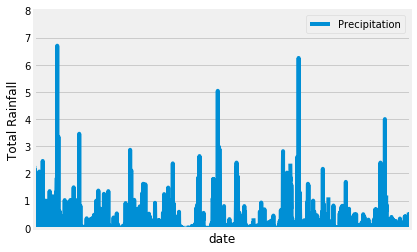

In [29]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(ylim=(0,8))
plt.ylabel("Total Rainfall")
plt.xticks([])



In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()


,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [22]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurement.station).group_by(Measurement.station).count()
print(station_count)

9


In [23]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_data_count = session.query(Measurement.station,func.count(Measurement.prcp)).group_by(Measurement.station)\
.order_by(func.count(Measurement.prcp).desc()).all()
station_data_count

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

![describe](Images/describe.png)

In [24]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

session.query(func.min(Measurement.tobs).label("Min"),\
             func.max(Measurement.tobs).label("Max"),\
             func.avg(Measurement.tobs).label("AVG")).filter(Measurement.station == 'USC00519281').all()


[(54.0, 85.0, 71.66378066378067)]

In [30]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

Temp_results = session.query(Measurement.date,Measurement.tobs).\
filter(Measurement.date <= '2017-08-23', Measurement.date >= '2016-08-24').\
filter(Measurement.station == 'USC00519281').all()
df_temp = pd.DataFrame(Temp_results)
df_temp.set_index('date', inplace = True)


Text(0.5, 1.0, "#Observations per Temperature for 'USC00519281'")

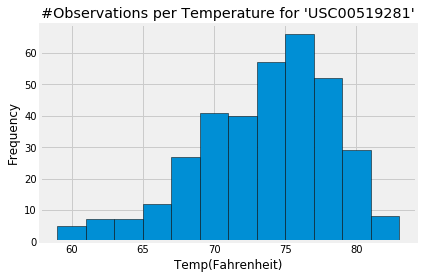

In [26]:
df_temp.hist(bins = 12,edgecolor = 'black')
plt.ylabel("Frequency")
plt.xlabel("Temp(Fahrenheit)")
plt.title("#Observations per Temperature for 'USC00519281'")


## Step 2 - Climate App
Now that you have completed your initial analysis, design a Flask API based on the queries that you have just developed.
Use FLASK to create your routes.

In [25]:
#import dependencies
from flask import Flask
import json

In [26]:
last_date_ints = [int(s) for s in last_date[0].split('-')]
year_ago = dt.date(*last_date_ints) - dt.timedelta(days=364)

In [27]:
# Flask Setup
app = Flask(__name__)

In [28]:
# / Homepage: List all routes that are available.
@app.route("/")
def home():  # returns a series of clickable links to the valid urls in this api
    return (
        """
        <div>
         <h2>Valid Routes:</h2>
         <a href="/api/v1.0/precipitation">/api/v1.0/precipitation</a><br/>
         <a href="/api/v1.0/stations">/api/v1.0/stations</a><br/>
         <a href="/api/v1.0/tobs">/api/v1.0/tobs</a><br/>
         <a href="/api/v1.0/2012-02-28/">/api/v1.0/&lt;start&gt;</a><br/>
         <a href="/api/v1.0/2012-02-28/2012-03-05">/api/v1.0/&lt;start>/&lt;end&gt;</a><br/>
        </div>
        """
    )

In [29]:
#Convert the query results to a Dictionary using date as the key and prcp as the value.
#Return the JSON representation of your dictionary.
@app.route("/api/v1.0/precipitation")
def precipitation():
    # THIS FUNCTION NEEDS TO BE RECONFIGURED TO ACCOUNT FOR MULTIPLE DATES IN THE QUERY RESULT DUE TO DIFFERENT STATIONS
    # HAVING THE SAME DATE
    precipitation_session = Session(engine)  # start new engine session
    df = pd.DataFrame(results)  # convert results to pandas dataframe
    df.set_index('date', inplace=True)  # order by date
    return df.to_json(orient='values')  # return json values

In [30]:
#Return a JSON list of stations from the dataset.
@app.route("/api/v1.0/stations")
def stations():
    stations_session = Session(engine)  # start new engine session
    station_results = stations_session.query(Measurement.station).group_by(Measurement.station).all()  # run query
    df = pd.DataFrame(station_results)  # convert results to pandas dataframe
    return df.to_json()  # return json
    

In [31]:
#query for the dates and temperature observations from a year from the last data point.
#Return a JSON list of Temperature Observations (tobs) for the previous year.
@app.route("/api/v1.0/tobs")
def temp_obs():
    temp_obs_session = Session(engine)  # start new engine session
    tobs_results = temp_obs_session.query(Measurement.date, Measurement.tobs.label("Observed Temperature")).filter \
        (Measurement.date >= year_ago).order_by(Measurement.date).all()  # run query
    df = pd.DataFrame(tobs_results)  # convert results to pandas dataframe
    return df.to_json()  # return json

In [32]:
# add duplicate routes to account for the user possibly not adding a terminal slash in the url
# define default value for url parameter if it is not user-defined
#Return a JSON list of the minimum temperature, the average temperature, and the max temperature for a given start date
#When given the start only, calculate TMIN, TAVG, and TMAX for all dates greater than and equal to the start date.
@app.route("/api/v1.0/<start>", defaults={'end': None})
@app.route("/api/v1.0/<start>/", defaults={'end': None})
@app.route("/api/v1.0/<start>/<end>")
@app.route("/api/v1.0/<start>/<end>/")
def calc_temps(start, end):
    calc_temps_session = Session(engine)
    if end:
        temp_results = calc_temps_session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs),
                                                func.max(Measurement.tobs)).filter(Measurement.date >= start). \
            filter(Measurement.date <= end).all()
    else:
        temp_results = calc_temps_session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs),
                                                func.max(Measurement.tobs)).filter(Measurement.date >= start).all()

    output_dict = {'TMIN': temp_results[0][0], 'TAVG': temp_results[0][1], 'TMAX': temp_results[0][2]}
    return json.dumps(output_dict)

In [34]:
if __name__ == "__main__":  # run app
    app.debug = True
    app.run(host='0.0.0.0', port=5010)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Restarting with stat


SystemExit: 1

In [ ]:

exit

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2016-04-10', '2016-04-17'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
#assuming my trip was 4-10-19 to 4-17-19 and this data doesnt exist for 2018 I'll look at 2017
print(calc_temps('2016-04-10','2016-04-17'))

In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
#start = '2016-04-10'
#end = '2016-04-17'
temps = calc_temps('2012-02-28','2012-03-05')
avg = temps[0][1]
minimum = temps[0][0]
maximum = temps[0][2]
diff = maximum-minimum

plt.bar("AVG Temp",avg,yerr = diff)
plt.title("Trip Avg Temp")
plt.ylabel("Temperature")


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


In [ ]:
#Merge Measurement and Station on id
trip_s = '2016-04-10'
trip_e = '2016-04-17'
sel = [Measurement.prcp.label("Rain Amount"), Station.station.label("Station #"), \
                              Station.name.label("Name"), Station.latitude.label("lat"),\
                              Station.longitude.label("lon")]
merge_tables = session.query(*sel).filter(Measurement.station == Station.station).filter(Measurement.date <= trip_e )\
.filter(Measurement.date >= trip_s).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()


print(merge_tables)

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
